In [42]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import importlib
import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

import pyhf

logging.info("pyhf version: {}".format(pyhf.__version__))


#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


%config InlineBackend. figure_format = 'retina'

INFO:root:pyhf version: 0.6.3


# Fitting Procedure

* Heavy–quark Yukawa couplings to the light (heavy) CP–even Higgs bosons for type II 2HDM.

Correction            |           Type II             | 
----------------------|:-----------------------------:|
1+ $\Delta^{h^0}_t$   | $\frac{\cos\alpha}{\sin\beta}$  |  
1+ $\Delta^{h^0}_b$   | $-\frac{\sin\alpha}{\cos\beta}$ |  
1+ $\Delta^{H^0}_t$   | $\frac{\sin\alpha}{\sin\beta}$  |  
1+ $\Delta^{H^0}_b$   | $\frac{\cos\alpha}{\cos\beta}$  |  

* Triple Higgs interactions involving the neutral CP–even Higgs fields in the 2HDM.

$$\lambda_{h^0h^0H^0} = \frac{\cos(\beta-\alpha)}{\sin2\beta}\left[\sin2\alpha(2m^2_{h^0}+m^2_{H^0})-\frac{2M_{12}^2}{\sin2\beta}(3\sin2\alpha-\sin2\beta) \right]$$

* The cross section is propotional to amplitude square: 

$$\sigma \propto|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2 \propto $$

$$\left|\left[ (1+ \Delta^{H^0}_t)\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2 \right] + \left[(1+ \Delta^{H^0}_b)\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2\right] \right|^2 =$$

$$\left| \left[ (1+ \Delta^{H^0}_t)+(1+ \Delta^{H^0}_b)\right]\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2  \right|^2$$

* The relation between upper limit for number of signal and  number of survival Monte Carlo signal samples at benchmark point can be written in

$$\frac{N^{sig}_{\text{limit}}}{N^{sig}_{\text{MC}}}= \frac{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2(\cos(\beta-\alpha),M_{12}^2)}{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2_{\tan\beta=5,M_{12}^2=400000,\cos(\beta-\alpha)=0.08}}$$


* Our benchmark point is at $\tan\beta$=5, $M_{12}^2$=400000$\text{GeV}^2$, $\cos(\beta-\alpha)$=0.08, $M_H=M_A=M_{H^{\pm}}$=1000GeV, $M_h$=125GeV. 
> At this benchmark point, we the $H\to h h $ is dominant decay mode. ($Br(H\to h h)\approx $0.85)


* $N^{sig}_{\text{limit}}$ is the function of $\cos(\beta-\alpha)$ and $M_{12}^2$.

$$N^{sig}_{\text{limit}}= \frac{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2(\cos(\beta-\alpha),M_{12}^2)}{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2_{\tan\theta=5,M_{12}^2=400000,\cos(\beta-\alpha)=0.08}}\times N^{sig}_{\text{MC}}$$

* $N^{sig}_{\text{MC}}$, $N^{bkg}_{\text{MC}}$ can be obtained after we apply ML classifier.


* Treat $N^{sig}_{\text{MC}}$, $N^{bkg}_{\text{MC}}$ as 1 bin case and use CLs method to get expected signal strengths in $2\sigma$ and $1\sigma$ bands at 95%C.L.

* Translate expected signal strengths to be number of signal events in $2\sigma$ and $1\sigma$ bands at 95%C.L.
$$1\sigma\,\, \text{band} = [s_{-1\sigma}\times N^{sig}_{\text{MC}},s_{1\sigma}\times N^{sig}_{\text{MC}}]$$
$$2\sigma\,\, \text{band} = [s_{-2\sigma}\times N^{sig}_{\text{MC}},s_{2\sigma}\times N^{sig}_{\text{MC}}]$$

* After scan $\cos(\beta-\alpha)$ and $M_{12}^2$, we can pick allowed sets which let $N^{sig}_{\text{limit}}$ in the $1\sigma\,\, \text{band}$ or $2\sigma\,\, \text{band}$ regions.


Ref: [Higgs pair production via gluon fusion in the Two-Higgs-Doublet Model](https://arxiv.org/abs/1407.0281)  
Ref: [Exploring sizable triple Higgs couplings in the 2HDM](https://arxiv.org/abs/2005.10576)  
Ref: [LHC Search of New Higgs Boson via Resonant Di-Higgs Production with Decays into 4W](https://arxiv.org/abs/1706.05980)

## Couplings in 2HDM Type II

In [43]:
"""
Convention:
0 ≤ \beta - \alpha ≤ 𝜋


0 < \beta <  𝜋/2
"""


"""
lambda_Hhh(cb_a, m12s, tb, mH, mh=125 )
"""

def lambda_Hhh(cb_a, m12s, tb, mH, mh=125 ):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    ########################################################################
    """
    arXiv:2005.10576v2 Eq. (32)
    """
    
    part_a = (2*mh**2+mH**2-4*(m12s/(np.sin(b)*np.cos(b))))*np.sin(b_a)**2
    part_b = 2*1/np.tan(2*b)*(2*mh**2+mH**2-3*(m12s/(np.sin(b)*np.cos(b))))*np.sin(b_a)*cb_a
    part_c = (2*mh**2+mH**2-2*(m12s/(np.sin(b)*np.cos(b))))*cb_a**2

    return -1*cb_a/246*(part_a+part_b-part_c)
    ########################################################################
    
    
"""
ghU(cb_a, tb, type)
"""
def ghU(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    else:
        return np.cos(a)/np.sin(b)

    
"""
ghD(cb_a, tb, type)
"""
def ghD(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)

    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.cos(a)/np.sin(b)  
    elif type == 2:
        return -1*np.sin(a)/np.cos(b)  
    elif type == 3:
        return np.cos(a)/np.sin(b) 
    elif type == 4:
        return -1*np.sin(a)/np.cos(b)   


"""
ghL(cb_a, tb, type)
"""
def ghL(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.cos(a)/np.sin(b)  
    elif type == 2:
        return -1*np.sin(a)/np.cos(b)  
    elif type == 3:
        return -1*np.sin(a)/np.cos(b)
    elif type == 4:
        return np.cos(a)/np.sin(b)  



"""
gHU(cb_a, tb, type)
"""
def gHU(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)

    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    else:
        return np.sin(a)/np.sin(b)

    
"""
gHD(cb_a, tb, type)
"""
def gHD(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.sin(a)/np.sin(b)  
    elif type == 2:
        return np.cos(a)/np.cos(b)  
    elif type == 3:
        return np.sin(a)/np.sin(b)
    elif type == 4:
        return np.cos(a)/np.cos(b) 
    
"""
gHL(cb_a, tb, type)
"""
def gHL(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.sin(a)/np.sin(b)  
    elif type == 2:
        return np.cos(a)/np.cos(b)  
    elif type == 3:
        return np.cos(a)/np.cos(b)
    elif type == 4:
        return np.sin(a)/np.sin(b) 

"""
gAU(cb_a, tb, type)
"""
def gAU(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)

    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    else:
        return np.cos(b)/np.sin(b)

    
"""
gAD(cb_a, tb, type)
"""
def gAD(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return -np.cos(b)/np.sin(b)
    elif type == 2:
        return tb
    elif type == 3:
        return -np.cos(b)/np.sin(b)
    elif type == 4:
        return tb
    
"""
gAL(cb_a, tb, type)
"""
def gAL(cb_a, tb, type):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return -np.cos(b)/np.sin(b)
    elif type == 2:
        return tb
    elif type == 3:
        return tb
    elif type == 4:
        return -np.cos(b)/np.sin(b)



"""
gU(tb, type)
"""
def gU(tb, type):

    Mu, Mc, Mt = 0.0, 0.0, 173.07
    Md, Ms, Mb = 0.0, 0.0, 4.78
    Me, Mmu, mta = 5.10998918e-04, 1.05658367e-01, 1.77684000e+00
    vev = 246

    b = np.arctan(tb)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    else:
        return np.array([Mu, Mc, Mt])*np.sqrt(2)/vev*(np.cos(b)/np.sin(b))*(-1)

"""
gD(tb, type)
"""
def gD(tb, type):

    Mu, Mc, Mt = 0.0, 0.0, 173.07
    Md, Ms, Mb = 0.0, 0.0, 4.78
    Me, Mmu, mta = 5.10998918e-04, 1.05658367e-01, 1.77684000e+00
    vev = 246

    b = np.arctan(tb)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.array([Md, Ms, Mb])*np.sqrt(2)/vev*(np.cos(b)/np.sin(b))*(-1)
    elif type == 2:
        return -np.array([Md, Ms, Mb])*np.sqrt(2)/vev*tb*(-1)
    elif type == 3:
        return -np.array([Md, Ms, Mb])*np.sqrt(2)/vev*tb*(-1)
    elif type == 4:
        return np.array([Md, Ms, Mb])*np.sqrt(2)/vev*(np.cos(b)/np.sin(b))*(-1)

"""
gL(tb, type)
"""
def gL(tb, type):

    Mu, Mc, Mt = 0.0, 0.0, 173.07
    Md, Ms, Mb = 0.0, 0.0, 4.78
    Me, Mmu, mta = 5.10998918e-04, 1.05658367e-01, 1.77684000e+00
    vev = 246

    b = np.arctan(tb)
    
    if type not in [1,2,3,4]:
        raise ValueError("Please let 'type' in [1,2,3,4]")
    elif type == 1:
        return np.array([Me, Mmu, mta])*np.sqrt(2)/vev*(np.cos(b)/np.sin(b))*(-1)
    elif type == 2:
        return -np.array([Me, Mmu, mta ])*np.sqrt(2)/vev*tb*(-1)
    elif type == 3:
        return np.array([Me, Mmu, mta ])*np.sqrt(2)/vev*(np.cos(b)/np.sin(b))*(-1)
    elif type == 4:
        return -np.array([Me, Mmu, mta ])*np.sqrt(2)/vev*tb*(-1)


    
"""
Constraint(cb_a, m12s, tb, mH, mh=125, luminosity = 3000, acceptance = 0.5, Xection = 0.01)

luminosity (fb^-1)
Xection (pd)

m_h:    125.00000
m_H:   1000.00000
m_A:   1001.00000
m_H+:   1001.00000
sin(b-a):      0.99612
lambda_6:      0.00000
lambda_7:      0.00000
m12^2: 400000.00000
tan(beta):      5.00000  (fix)


np.arctan(5) - 𝜋  ≤ \alpha ≤  np.arctan(5)

"""    
    
def Constraint_N(cb_a, m12s, tb, mH, mh=125, type=2, luminosity = 3000, acceptance = 0.5, Xection = 0.01):
    
    N_MC = luminosity*acceptance*(Xection*1000)
    
    numerator = ((1+gHU(cb_a, tb, type)) + (1+gHD(cb_a, tb, type)))**2 * (lambda_Hhh(cb_a, m12s, tb, mH, mh=125 )**2) * (1+ghD(cb_a, tb, type))**4
    
    cba = np.cos(np.arcsin(0.99612))
    denominator =  ((1+gHU(cba, 5, type)) + (1+gHD(cba, 5, type)))**2 * (lambda_Hhh(cba, 400000, 5, 1000, mh=125 )**2) * (1+ghD(cba, 5, type))**4
    
    return N_MC*(numerator/denominator) #




"""
Statistics
"""

def chi_square(n_s, n_b):
    
    #[(s+b - b) / sqrt(b)]^2
    
    chisquare = (n_s)**2/n_b
    
    return chisquare

def tmu_pyhf(n_sig, n_bkg):

    model = pyhf.simplemodels.hepdata_like(
        signal_data=[n_sig], bkg_data=[n_bkg], bkg_uncerts=[np.sqrt(n_bkg)]

    )

    test_mu = 1.0
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    par_bounds[model.config.poi_index] = [-10.0, 10.0]
    fixed_params = model.config.suggested_fixed()
    
    return pyhf.infer.test_statistics.tmu(test_mu, observations, model, init_pars, par_bounds, fixed_params)


def qmu_tilde_pyhf(n_sig, n_bkg):

    model = pyhf.simplemodels.hepdata_like(
        signal_data=[n_sig], bkg_data=[n_bkg], bkg_uncerts=[np.sqrt(n_bkg)]

    )

    test_mu = 1.0
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    fixed_params = model.config.suggested_fixed()
    
    return pyhf.infer.test_statistics.qmu_tilde(test_mu, observations, model, init_pars, par_bounds, fixed_params)




In [44]:
# %%time
# start = time.time()

# b_tag_eff = 0.77**4

# dictionary = {
#               # "sig_Xection" : (0.9864/1000),  #ppH (pb)  type 1
#               # "sig_Branching_ratio" : 0.88221*0.62102*0.62102, #type 1
#               "sig_Xection" : (0.81186/1000),  #ppH (pb) type 2
#               "sig_Branching_ratio" : 0.8715*0.3560*0.3560, #type 2
#               "sig_acceptance": 0.096102*b_tag_eff,
#               "ttbar_bkg_Xection" : 260.3554,  # ttbar (pb)
#               "ttbar_bkg_acceptance" : 5.000000e-07*b_tag_eff*0.192,
#               "QCD_bkg_Xection" : 11087.8358304,  # ppjjjj (pb)
#               "QCD_bkg_acceptance" : 1.564000e-07*b_tag_eff*0.015,
#               "luminosity": 3000
#               }
    
    
# n_sig = dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]*dictionary["sig_acceptance"]*dictionary["luminosity"]*1000  
# n_bkg = (dictionary["ttbar_bkg_Xection"]*dictionary["ttbar_bkg_acceptance"] + dictionary["QCD_bkg_Xection"]*dictionary["QCD_bkg_acceptance"])*dictionary["luminosity"]*1000

# logging.info("# of sig survival: {}".format(n_sig))
# logging.info("# of bkg survival: {}".format(n_bkg))
# logging.info("Z= {}".format(n_sig/np.sqrt(n_bkg)))
# time.sleep(1)

# n_slice = 100
# cb_a = np.linspace(-1 , 1,  n_slice)
# m12_s = np.linspace(1E+5, 1E+6,  n_slice)

# """
# numpy vectorize method
# """

# # cba, m12s = np.meshgrid(cb_a, m12_s)
# # tb = np.full((n_slice, n_slice), 5)
# # mH = np.full((n_slice, n_slice), 1000)
# # mh = np.full((n_slice, n_slice), 125)
# # type = np.full((n_slice, n_slice), 1)
# # luminosity = np.full((n_slice, n_slice), dictionary["luminosity"])
# # acceptance = np.full((n_slice, n_slice), dictionary["sig_acceptance"])
# # Xection = np.full((n_slice, n_slice), dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"])

# # constraint_n = np.vectorize(Constraint_N)(cba, m12s, tb, mH, mh, type, luminosity, acceptance, Xection)
# # constraint_n = Constraint_N(cba, m12s, tb, mH, mh, type, luminosity, acceptance, Xection)


# """
# multiprocessing method
# """
# # ref: https://www.maxlist.xyz/2020/03/20/multi-processing-pool/

# cba, m12s = np.meshgrid(cb_a, m12_s)
# tb = np.full((n_slice, n_slice), 5).reshape(n_slice*n_slice,)
# mH = np.full((n_slice, n_slice), 1000).reshape(n_slice*n_slice,)
# mh = np.full((n_slice, n_slice), 125).reshape(n_slice*n_slice,)
# type = np.full((n_slice, n_slice), 2).reshape(n_slice*n_slice,)
# luminosity = np.full((n_slice, n_slice), dictionary["luminosity"]).reshape(n_slice*n_slice,)
# acceptance = np.full((n_slice, n_slice), dictionary["sig_acceptance"]).reshape(n_slice*n_slice,)
# Xection = np.full((n_slice, n_slice), dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]).reshape(n_slice*n_slice,)

# tmp = []
# for element in zip(cba.reshape(n_slice*n_slice,), m12s.reshape(n_slice*n_slice,), tb, mH, mh, type, luminosity, acceptance, Xection):
#     tmp.append(element)



# from multiprocessing import Process, Pool

# nb_threads = 40

# if __name__ == '__main__':

#     pool = Pool(nb_threads)

#     pool_outputs = pool.starmap_async(Constraint_N, tmp)
#     # print('將不會阻塞並和 pool.map_async 並行觸發')

#     # close 和 join 是確保主程序結束後，子程序仍然繼續進行
#     pool.close()
#     pool.join()


# constraint_n = np.array(pool_outputs.get()).reshape(n_slice, n_slice)


# finish = time.time()
# logging.info("Total TIme: {} min".format((finish-start)/60))


In [45]:
%%time
def Z(s,b):
    z =np.sqrt(2*((s+b)*np.log(1+s/b)-s))
#     z = s/np.sqrt(b)
    return z

yukawa_type = 4

if yukawa_type == 1:
  plot_title = "Type-I"
  xection =  (0.9864/1000) #ppH (pb)  type 1
  total_branching_ratio = 0.88221*0.62102*0.62102 #type 1

elif yukawa_type == 2:
  plot_title = "Type-II"
  xection = (0.81186/1000) #ppH (pb)
  total_branching_ratio = 0.8715*0.3560*0.3560

elif yukawa_type == 3:
  plot_title = "Type-III"
  xection = (0.83234/1000) #ppH (pb)
  total_branching_ratio = 0.87279*0.32968*0.32968

elif yukawa_type == 4:
  plot_title = "Type-IV"
  xection = (0.98173/1000) #ppH (pb)
  total_branching_ratio = 0.88087*0.64835*0.64835

b_tag_eff = 0.77**4
dictionary = {
              "sig_Xection" : xection,  
              "sig_Branching_ratio" : total_branching_ratio, 
              "sig_CUT_acceptance": 0.106051*b_tag_eff,
              "sig_BDT_acceptance": 0.096001*b_tag_eff,
              "sig_CNN_acceptance": 0.096102*b_tag_eff,
              "ttbar_bkg_Xection" : 260.3554,  # ttbar (pb)
              "ttbar_CUT_acceptance" : 0.000002*b_tag_eff*0.192,
              "ttbar_BDT_acceptance" : 5e-07*b_tag_eff*0.192,
              "ttbar_CNN_acceptance" : 4e-07*b_tag_eff*0.192,
              "QCD_bkg_Xection" : 11087.8358304,  # ppjjjj (pb)
              "QCD_CUT_acceptance" : 0.000008*b_tag_eff*0.015,
              "QCD_BDT_acceptance" : 7.819e-07*b_tag_eff*0.015,
              "QCD_CNN_acceptance" : 1.564000e-07*b_tag_eff*0.015,
              "luminosity": 3000
              }
    
    
n_sig_cut = dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]*dictionary["sig_CUT_acceptance"]*dictionary["luminosity"]*1000  
n_sig_bdt = dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]*dictionary["sig_BDT_acceptance"]*dictionary["luminosity"]*1000  
n_sig_cnn = dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]*dictionary["sig_CNN_acceptance"]*dictionary["luminosity"]*1000  
n_bkg_cut = (dictionary["ttbar_bkg_Xection"]*dictionary["ttbar_CUT_acceptance"] + dictionary["QCD_bkg_Xection"]*dictionary["QCD_CUT_acceptance"])*dictionary["luminosity"]*1000
n_bkg_bdt = (dictionary["ttbar_bkg_Xection"]*dictionary["ttbar_BDT_acceptance"] + dictionary["QCD_bkg_Xection"]*dictionary["QCD_BDT_acceptance"])*dictionary["luminosity"]*1000
n_bkg_cnn = (dictionary["ttbar_bkg_Xection"]*dictionary["ttbar_CNN_acceptance"] + dictionary["QCD_bkg_Xection"]*dictionary["QCD_CNN_acceptance"])*dictionary["luminosity"]*1000

logging.info("Cut-base: # of sig survival: {:.3f} # of bkg survival: {:.3f} Z= {:.3f}".format(n_sig_cut, n_bkg_cut, Z(n_sig_cut,n_bkg_cut)))
logging.info("BDT-base: # of sig survival: {:.3f} # of bkg survival: {:.3f} Z= {:.3f}".format(n_sig_bdt, n_bkg_bdt, Z(n_sig_bdt,n_bkg_bdt)))
logging.info("CNN-base: # of sig survival: {:.3f} # of bkg survival: {:.3f} Z= {:.3f}".format(n_sig_cnn, n_bkg_cnn, Z(n_sig_cnn,n_bkg_cnn)))


scan_results = pd.read_csv("./scan_results_type_"+str(yukawa_type)+"_10000_m12s_cba.csv")
constraint_n_cut = scan_results["Xection_fb"]*scan_results["BRHhh"]*(scan_results["BRhbb"]**2)*dictionary["luminosity"]*dictionary["sig_CUT_acceptance"]
constraint_n_bdt = scan_results["Xection_fb"]*scan_results["BRHhh"]*(scan_results["BRhbb"]**2)*dictionary["luminosity"]*dictionary["sig_BDT_acceptance"]
constraint_n_cnn = scan_results["Xection_fb"]*scan_results["BRHhh"]*(scan_results["BRhbb"]**2)*dictionary["luminosity"]*dictionary["sig_CNN_acceptance"]

constraint_n_cut = Z(np.array(constraint_n_cut),n_bkg_cut)
constraint_n_bdt = Z(np.array(constraint_n_bdt),n_bkg_bdt)
constraint_n_cnn = Z(np.array(constraint_n_cnn),n_bkg_cnn)


n_slice = int(np.sqrt(len(scan_results)))
constraint_n_cut = np.nan_to_num(np.array(constraint_n_cut).reshape(n_slice, n_slice))
constraint_n_bdt = np.nan_to_num(np.array(constraint_n_bdt).reshape(n_slice, n_slice))
constraint_n_cnn = np.nan_to_num(np.array(constraint_n_cnn).reshape(n_slice, n_slice))

scan_results_cb_a = np.array(scan_results["cba"]).reshape(n_slice, n_slice)
scan_results_m12s = np.array(scan_results["m12s"]).reshape(n_slice, n_slice)


cb_a = np.linspace(-1 , 1,  n_slice)
m12_s = np.linspace(1E+5, 1E+6,  n_slice)

cba, m12s = np.meshgrid(cb_a, m12_s)


INFO:root:Cut-base: # of sig survival: 40.656 # of bkg survival: 1508.610 Z= 1.042
INFO:root:BDT-base: # of sig survival: 36.803 # of bkg survival: 163.502 Z= 2.779
INFO:root:CNN-base: # of sig survival: 36.842 # of bkg survival: 48.519 Z= 4.771


CPU times: user 22.3 ms, sys: 571 µs, total: 22.9 ms
Wall time: 21.3 ms


In [46]:
# Oranges = cm.get_cmap('Oranges_r', 256)
# newcolors = Oranges(np.linspace(2, 0, 256))
# white = np.array([256/256, 256/256, 256/256, 1])
# newcolors[-1:, :] = white
# newcolors[:-80, :] = white
# newcmap = ListedColormap(newcolors, name='OrangeWhite')

# fig, ax = plt.subplots(1,1, figsize=(8,8))


# plt.imshow(constraint_n_cut,
#             origin = "lower",
#             # vmin = 0, vmax = 2.5,
#             # cmap=newcmap,
#             )

# # ax.imshow(constraint_n_cnn,
# #             origin = "lower",
# #             vmin = 0, vmax = 2,
# #             cmap=newcmap,
# #             )

# plt.colorbar()  

# plt.show()

# Upper Limit of Signal Strength by CLs Method

Ref :[pyhf.infer.intervals.upperlimit](https://scikit-hep.org/pyhf/_generated/pyhf.infer.intervals.upperlimit.html?highlight=limit#pyhf.infer.intervals.upperlimit)


In [47]:
# %%time
# model = pyhf.simplemodels.hepdata_like(
#     signal_data=[n_sig], bkg_data=[n_bkg], bkg_uncerts=[np.sqrt(n_bkg)]
    
# )
# # print(model)

# # print("Explore model")
# # print(f"  channels: {model.config.channels}")
# # print(f"     nbins: {model.config.channel_nbins}")
# # print(f"   samples: {model.config.samples}")
# # print(f" modifiers: {model.config.modifiers}")
# # print(f"parameters: {model.config.parameters}")
# # print(f"  nauxdata: {model.config.nauxdata}")
# # print(f"   auxdata: {model.config.auxdata}")

# # print("Expected data: ", model.expected_data([1.0, 1.0]))
# # print("Expected actualdata: ", model.expected_actualdata([1.0, 1.0]))
# # print("Expected auxdata: ", model.expected_auxdata([1.0, 1.0, 0.0]))

# # init_pars = model.config.suggested_init()
# # bounds = model.config.suggested_bounds()
# # print("init_pars: ", init_pars)
# # print("bounds: ", bounds)
# # print("the index of the parameter: ", model.config.poi_index)

# observations = [n_bkg] + model.config.auxdata  # this is a common pattern!

# # model = pyhf.simplemodels.hepdata_like(
# #     signal_data=[1.61], bkg_data=[47.2], bkg_uncerts=[np.sqrt(47.2)]
    
# # )
# # observations = [47.2] + model.config.auxdata  # this is a common pattern!

# logging.info("observations: {}".format(observations))


# scan = np.linspace(0, 10, 1001)

# obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
#                                                                         observations, 
#                                                                         model, 
#                                                                         scan, 
#                                                                         return_results=True
#                                                                         )


# print("CLs: {:.3f}".format(obs_limit))
# print("CLexp: {:.4f}, −2σ: {:.4f}, −1σ: {:.4f}, 0σ: {:.4f}, 1σ: {:.4f}, 2σ: {:.4f} ".format(obs_limit,exp_limits[0],exp_limits[1],exp_limits[2],exp_limits[3],exp_limits[4]))

In [48]:

# mu_test = 1.2454
# CLs_asy, CL_asy, expected_asy, expected_set_asy = pyhf.infer.hypotest(
#                                 mu_test, 
#                                 observations, 
#                                 model, 
#                                 return_tail_probs=True,  #returning CLs and [CL_s+b, CL_b]
#                                 return_expected = True, # returning CLexp
#                                 return_expected_set=True, #returning (−2,−1,0,1,2)\sigma CLexp
#                                 test_stat="qtilde", # 
#                                 calctype="asymptotics" #default
#                             )

# print("CLs: {:.3f}, CL_sb: {:.3f}, CL_b: {:.3f} ".format(CLs_asy, CL_asy[0], CL_asy[1]))
# print("CLexp: {:.4f}, −2σ: {:.4f}, −1σ: {:.4f}, 0σ: {:.4f}, 1σ: {:.4f}, 2σ: {:.4f} ".format(expected_asy,expected_set_asy[0],expected_set_asy[1],expected_set_asy[2],expected_set_asy[3],expected_set_asy[4]))


# Pick Allowed Parameter sets

In [49]:
# %%time

# Limit = {"−2sigma": exp_limits[0],
#          "−1sigma": exp_limits[1], 
#          "expected": exp_limits[2],
#          "1sigma": exp_limits[3], 
#          "2sigma": exp_limits[4]
#         }

# # Limit = {"−2sigma": 0.5,
# #          "−1sigma": 0.75, 
# #          "expected": 1,
# #          "1sigma": 1.25, 
# #          "2sigma": 1.50
# #         }


# """
# 1σ
# """
# n_low_1 = n_sig*Limit["−1sigma"]
# n_high_1 = n_sig*Limit["1sigma"]

# print("1\sigma: [{} , {}] ".format(n_low_1,n_high_1))

# "2σ"
# n_low_2 = n_sig*Limit["−2sigma"]
# n_high_2 = n_sig*Limit["2sigma"]
# print("2\sigma: [{} , {}] ".format(n_low_2,n_high_2))

# # constraint_alowed_1 = np.where(constraint_n > n_low_1, constraint_n, 0 )
# # constraint_alowed_1 = np.where(constraint_alowed_1 < n_high_1, constraint_alowed_1, 0 )
# # constraint_alowed_1 = np.where(constraint_n < n_high_1, constraint_n, 0 )
# constraint_alowed_1 = np.where(constraint_n <= 1, constraint_n, 0 )


# constraint_alowed_1_boundary = np.where(constraint_alowed_1 > 0, 1, constraint_alowed_1 )
# allowed_region_1 = np.where(constraint_alowed_1 != 0)


# # constraint_alowed_2 = np.where(constraint_n > n_low_2, constraint_n, 0 )
# # constraint_alowed_2 = np.where(constraint_alowed_2 < n_high_2, constraint_alowed_2, 0 )
# # constraint_alowed_2 = np.where(constraint_n < n_high_2, constraint_n, 0 )
# constraint_alowed_2 = np.where(constraint_n <= 2, constraint_n, 0 )




# constraint_alowed_2_boundary = np.where(constraint_alowed_2 > 0, 1, constraint_alowed_2 )
# allowed_region_2 = np.where(constraint_alowed_2 != 0)

# print("len(allowed_region_1)", len(allowed_region_1[0]))
# print("len(allowed_region_2)", len(allowed_region_2[0]))

# ##############################

# # # constraint_alowed_1 = np.where(constraint_n > n_low_1, constraint_n, 0 )
# # constraint_alowed_1 = np.where(constraint_n < np.sqrt(2.3*n_bkg), constraint_n, 0 )
# # constraint_alowed_1_boundary = np.where(constraint_alowed_1 > 0, 1, constraint_alowed_1 )
# # allowed_region_1 = np.where(constraint_alowed_1 != 0)


# # # constraint_alowed_2 = np.where(constraint_n > 2.5*n_bkg, constraint_n, 0 )
# # constraint_alowed_2 = np.where(constraint_n < np.sqrt(6.18*n_bkg), constraint_n, 0 )
# # constraint_alowed_2_boundary = np.where(constraint_alowed_2 > 0, 1, constraint_alowed_2 )
# # allowed_region_2 = np.where(constraint_alowed_2 != 0)

# # print("len(allowed_region_1)", len(allowed_region_1))
# # print("len(allowed_region_2)", len(allowed_region_2))



# # chi = chi_square(constraint_alowed_2[allowed_region_2], n_bkg)
# # min_index = np.where(chi == np.min(chi))[0][0]
# # cba_min = cba[allowed_region_2][min_index]
# # m12s_min = m12s[allowed_region_2][min_index]
# # x_min_index, y_min_index = np.where(cba[0,:] == cba_min), np.where(m12s[:,0] == m12s_min)

In [50]:
%%time

def allow_region_boundary(constraint_value, sigma):

    constraint_alowed = np.where(constraint_value <= sigma, constraint_value, -1 )
    constraint_alowed_boundary = np.where(constraint_alowed >= 0, 1, constraint_alowed )
    allowed_region = np.where(constraint_alowed != -1)

    return constraint_alowed_boundary, allowed_region



constraint_alowed_1_boundary_cut, allowed_region_1_cut = allow_region_boundary(constraint_n_cut, 1)
constraint_alowed_2_boundary_cut, allowed_region_2_cut = allow_region_boundary(constraint_n_cut, 2)

constraint_alowed_1_boundary_bdt, allowed_region_1_bdt = allow_region_boundary(constraint_n_bdt, 1)
constraint_alowed_2_boundary_bdt, allowed_region_2_bdt = allow_region_boundary(constraint_n_bdt, 2)

constraint_alowed_1_boundary_cnn, allowed_region_1_cnn = allow_region_boundary(constraint_n_cnn, 1)
constraint_alowed_2_boundary_cnn, allowed_region_2_cnn = allow_region_boundary(constraint_n_cnn, 2)


logging.info("Cut-base len(allowed_region_1): {:} len(allowed_region_2): {:}".format(len(allowed_region_1_cut[0]), len(allowed_region_2_cut[0])))
logging.info("BDT len(allowed_region_1): {:} len(allowed_region_2): {:}".format(len(allowed_region_1_bdt[0]), len(allowed_region_2_bdt[0])))
logging.info("CNN len(allowed_region_1): {:} len(allowed_region_2): {:}".format(len(allowed_region_1_cnn[0]), len(allowed_region_2_cnn[0])))


INFO:root:Cut-base len(allowed_region_1): 2998 len(allowed_region_2): 4177
INFO:root:BDT len(allowed_region_1): 2059 len(allowed_region_2): 2663
INFO:root:CNN len(allowed_region_1): 1808 len(allowed_region_2): 2136


CPU times: user 7.73 ms, sys: 124 µs, total: 7.86 ms
Wall time: 6.66 ms


<timed exec>:37: UserWarning: No contour levels were found within the data range.
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral


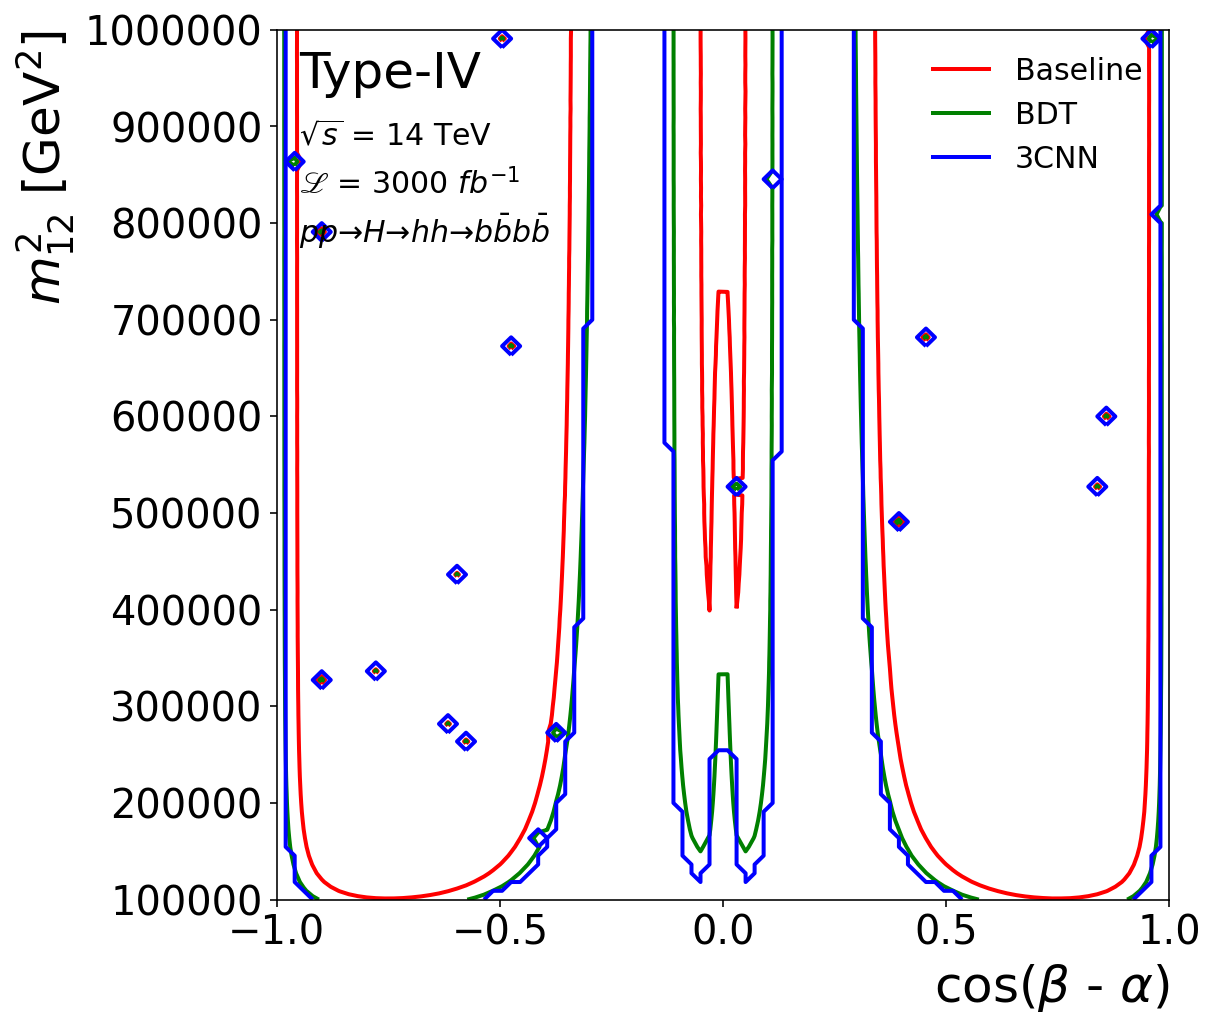

CPU times: user 847 ms, sys: 274 ms, total: 1.12 s
Wall time: 1.12 s


In [51]:
%%time
fig, ax = plt.subplots(1,1, figsize=(8,8))

# plt.title("Pythia Default",fontsize=25)

# plt.scatter(cba[allowed_region_2_cut],m12s[allowed_region_2_cut], marker=".", s=20 ,
#             # c=constraint_alowed_2_boundary,
#             cmap="autumn"
#            )


            
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=20)
# # cbar.set_ticks(np.arange(0.0, 25.0, 5))
# # cbar.set_ticks([0.0, 5, 10, 15, 25.0])



# Python contour plot
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

CS_2_sigma_cut = plt.contour(cba, m12s, constraint_n_cut, 
                            colors='red', 
                            linestyles="-", 
                            linewidths=2,
                            levels=[2],
                            corner_mask = 0
                            )

CS_2_sigma_bdt = plt.contour(cba, m12s, constraint_n_bdt, 
                            colors='green', 
                            linestyles="-", 
                            linewidths=2,
                            levels=[2],
                            corner_mask = 0
                            )
CS_2_sigma_cnn = plt.contour(cba, m12s, constraint_alowed_2_boundary_cnn, 
                            colors='blue', 
                            linestyles="-", 
                            linewidths=2,
                            levels=[2],
                            corner_mask = 0
                            )
# plt.clabel(CS_2_sigma_cnn, inline=True, fontsize=10)

CS_2_sigma_cut.collections[0].set_label("Baseline")
CS_2_sigma_bdt.collections[0].set_label("BDT")
CS_2_sigma_cnn.collections[0].set_label("3CNN")

# plt.scatter(0.08,400000, marker="s", s=40 , c='blue', label = "Benchmark")


plt.text(x=-0.95, y=940000, s=str(plot_title), fontsize=25, rotation=0)

plt.text(x=-0.95, y=880000, s="$\sqrt{s}$ = 14 TeV", fontsize=15, rotation=0)
plt.text(x=-0.95, y=830000, s="$\mathscr{L}$ = 3000 $fb^{-1}$", fontsize=15, rotation=0)
plt.text(x=-0.95, y=780000, s="$pp \\to H \\to hh \\to b\\bar{b}b\\bar{b}$", fontsize=15, rotation=0)

# plt.xlim((-0.8,0.8))
plt.xlim((-1.0,1.0))
# plt.ylim((100000,1200000))
plt.ylim((100000,1000000))


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.xlabel("cos($\\beta$ - $\\alpha$)", fontsize=25, horizontalalignment='right',x=1)
plt.ylabel('$m_{12}^2$ [$\mathrm{GeV}^2$]', fontsize=25,horizontalalignment='right',y=1)
plt.legend(bbox_to_anchor=(1.0, 1), ncol=1, fontsize=15,# markerscale=2., scatterpoints=1,
           edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
# plt.legend(loc="upper right", ncol=1, fontsize=20, markerscale=2., scatterpoints=1,
#            edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
           
plt.ticklabel_format(style='plain')

# plt.grid()

# plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig("../Plots/Type_"+str(yukawa_type)+"_m12s_cba.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [52]:
# %%time
# fig, ax = plt.subplots(1,1, figsize=(8,8))

# # plt.title("Pythia Default",fontsize=25)

# # plt.scatter(cba[allowed_region_1],m12s[allowed_region_1], marker=".", s=20 ,
# #             # c=constraint_alowed_2_boundary,
# #             cmap="autumn"
# #            )


            
# # cbar = plt.colorbar()
# # cbar.ax.tick_params(labelsize=20)
# # # cbar.set_ticks(np.arange(0.0, 25.0, 5))
# # # cbar.set_ticks([0.0, 5, 10, 15, 25.0])
# # plt.text(x=0.8+0.5, y=550000, s="$\chi^2$", fontsize=25, rotation=270)


# # Python contour plot
# # Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

# CS_2_sigma = plt.contour(cba, m12s, constraint_alowed_2_boundary, colors='purple', linestyles="--", linewidths=1)
# # CS_1_sigma = plt.contour(cba, m12s, constraint_alowed_1_boundary, colors='green', linestyles="-", linewidths=1)
# # plt.clabel(CS, inline=True, fontsize=10)

# CS_2_sigma.collections[0].set_label("2$\sigma$")
# # CS_1_sigma.collections[0].set_label("1$\sigma$")


# # plt.scatter(cba[y_min_index, x_min_index],m12s[y_min_index, x_min_index], marker="D", s=40 , c='lightgreen', label = "Best Fit")
# # plt.scatter(0.08,400000, marker="s", s=40 , c='blue', label = "Benchmark")




# plt.xlim((-0.8,0.8))
# # plt.xlim((0.,0.09))
# plt.ylim((100000,1200000))

# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y', labelsize=20)
# plt.xlabel("cos($\\beta$ - $\\alpha$)", fontsize=25, horizontalalignment='right',x=1)
# plt.ylabel('$m_{12}^2$ [$\mathrm{GeV}^2$]', fontsize=25,horizontalalignment='right',y=1)
# plt.legend(loc="upper left", ncol=2, fontsize=20, markerscale=2., scatterpoints=1,
#            edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
# plt.ticklabel_format(style='plain')
# # plt.grid()
# # plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# # plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.show()

In [53]:
# fig, ax = plt.subplots(1,1, figsize=(6,6))


# plt.title("Pythia Default",fontsize=25)


# tmp = np.where(m12s[allowed_region_2]== m12s[allowed_region_2][min_index])
# plt.scatter(cba[allowed_region_2][tmp],chi[tmp], marker=".", s=20 , c="r")

# plt.text(x=-0.7, y=27, s="$m_{12}^2$ = " + str(round(m12s[allowed_region_2][min_index])), fontsize=25)


# plt.hlines(xmin=-1,  xmax=1,y= np.sort(chi)[0],)

# plt.xlim((-0.8,0.8))
# plt.ylim((0,30))
# # plt.xlim((0.,0.09))
# # plt.ylim((100000,1000000))

# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y', labelsize=20)
# plt.xlabel("cos($\\beta$ - $\\alpha$)", fontsize=25,horizontalalignment='right',x=1)
# # plt.ylabel('$\\tilde{q}$', fontsize=25,horizontalalignment='right',y=1)
# plt.ylabel('$\chi^2$', fontsize=25,horizontalalignment='right',y=1)
# plt.legend(ncol=1, fontsize=20, markerscale=2., scatterpoints=1,
#            edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
# plt.ticklabel_format(style='plain')
# # plt.grid()
# # plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# # plt.subplots_adjust(wspace=0.5, hspace=0.5)



# plt.show()

In [54]:
# fig, ax = plt.subplots(1,1, figsize=(6,6))


# plt.title("Pythia Default",fontsize=25)


# tmp = np.where(cba[allowed_region_2]== cba[allowed_region_2][min_index])
# plt.scatter(m12s[allowed_region_2][tmp],chi[tmp], marker=".", s=20 , c="r")

# plt.text(x=120000, y=27, s="$cos(\\beta-\\alpha )$ = " + str(round(cba[allowed_region_2][min_index],3)), fontsize=25)




# # plt.xlim((-1,1))

# plt.xlim((100000,1000000))
# plt.ylim((0.,30))
# plt.xscale("log")

# # plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(which='both', axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)
# plt.xlabel("$m_{12}^2$ [$\mathrm{GeV}^2$]", fontsize=25,horizontalalignment='right',x=1)
# # plt.ylabel('$\\tilde{q}$', fontsize=25,horizontalalignment='right',y=1)
# plt.ylabel('$\chi^2$', fontsize=25,horizontalalignment='right',y=1)
# plt.legend(ncol=1, fontsize=20, markerscale=2., scatterpoints=1,
#            edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),

# # plt.MaxNLocator(10)
# # plt.locator_params(axis='x', nbins=10)
# ax.xaxis.set_minor_locator(MaxNLocator(3))
# # plt.ticklabel_format(style='plain')
# # plt.grid()
# # plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# # plt.subplots_adjust(wspace=0.5, hspace=0.5)



# plt.show()